<a href="https://colab.research.google.com/github/mchivuku/gan-networks/blob/master/GAN_Implementation_for_MNIST_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%load_ext autoreload

In [0]:
%matplotlib inline


In [0]:
%autoreload 2


**INSTALL PYTORCH and TORCH VISION**

https://jovianlin.io/pytorch-with-gpu-in-google-colab/

In [0]:
#!pip3 install http://download.pytorch.org/whl/cu80/torch-0.3.0.post4-cp36-cp36m-linux_x86_64.whl 
#!pip3 install torchvision
#!pip3 install tensorboardX
#!pip3 install --no-cache-dir -I pillow

#!pip3 install Pillow==4.0.0
#!pip3 install PIL
#!pip3 install image



**MOUNTING TO GOOGLE DRIVE**

Useful link: https://medium.com/deep-learning-turkey/google-colab-free-gpu-tutorial-e113627b9f5d

Testing the mount:

!ls "/content/drive/My Drive/"



```
from google.colab import drive
drive.mount('/content/drive/')

**Testing mount**
!ls "/content/drive/My Drive/"
```



In [9]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
#!ls "/content/drive/My Drive/"

##IMPORT Libaries

In [0]:
from IPython import display

from utils import Logger

import torch
from torch import nn, optim
from torch.autograd.variable import Variable
from torchvision import transforms, datasets

**LOAD DATA**

Root parameter to define where to save the data.

Train parameter is set to **true** because we are initializing the MNIST training dataset.

The **download parameter is set to true because we want to download** it if it’s not already present in our data folder.

The **transform parameter is set to none because we don’t want to apply any image manipulation transforms at this time.**



In [0]:
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=None)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=None)



In [16]:
len(mnist_trainset)


60000

In [17]:
len(mnist_testset)


10000

In [0]:
DATA_FOLDER = './data/'


## LOAD Data and transform

In [19]:
def mnist_data():
    compose = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((.5, .5, .5), (.5, .5, .5))
        ])
    out_dir = '{}/dataset'.format(DATA_FOLDER)
    return datasets.MNIST(root=out_dir, train=True, transform=compose, download=True)
  
## Create data loader, so that we can iterate over the data
# Load data
data = mnist_data()
# Create loader with data, so that we can iterate over it
data_loader = torch.utils.data.DataLoader(data, batch_size=100, shuffle=True)
# Num batches
num_batches = len(data_loader)
  

Processing...
Done!


#Build Networks

Now build networks - Generator and Discriminator

Discriminator
Generator

In [0]:
class DiscriminatorNet(nn.Module):
  '''
  three layer network
  '''
  def __init__(self):
    super(DiscriminatorNet,self).__init__()
    n_features = 784
    n_out = 1
    
    self.hidden0 = nn.Sequential( 
            nn.Linear(n_features, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3))
    self.hidden1 = nn.Sequential(
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3))
    self.hidden2 = nn.Sequential(
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3))
    
    self.out = nn.Sequential(torch.nn.Linear(256,n_out),torch.nn.Sigmoid())
   
  def forward(self,x):
    x = self.hidden0(x)
    x = self.hidden1(x)
    x = self.hidden2(x)
    x = self.out(x)
    return x
  
def images_to_vectors(images):
  return images.view(images.size(0), 784)
  
def vectors_to_images(vectors):
  return vectors.view(vectors.size(0), 1, 28, 28)
    
    

In [0]:
class GeneratorNet(torch.nn.Module):
    """
    A three hidden-layer generative neural network
    """
    def __init__(self):
        super(GeneratorNet, self).__init__()
        n_features = 100
        n_out = 784
        
        self.hidden0 = nn.Sequential(
            nn.Linear(n_features, 256),
            nn.LeakyReLU(0.2)
        )
        self.hidden1 = nn.Sequential(            
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2)
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2)
        )
        
        self.out = nn.Sequential(
            nn.Linear(1024, n_out),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x
  
## Generate Noise - vector
def noise(size):
  n = Variable(torch.randn(size, 100))
  if torch.cuda.is_available():
    return n.cuda() 
  return n

In [0]:
discriminator = DiscriminatorNet()
generator = GeneratorNet()
if torch.cuda.is_available():
  discriminator.cuda()
  generator.cuda()

# Optimization for the networks

In [0]:
# optimizers
lr  = 0.002
d_optimizer = optim.Adam(discriminator.parameters(),lr=lr)
g_optimizer = optim.Adam(generator.parameters(),lr=lr)

## Loss function
loss = nn.BCELoss()

# Number of steps to apply to the discriminator
d_steps = 1  # In Goodfellow et. al 2014 this variable is assigned to 1
# Number of epochs
num_epochs = 200




# Training

In [0]:
def real_data_target(size):
  data = Variable(torch.ones(size,1))
  if torch.cuda.is_available():return data.cuda()
  return data

def fake_data_target(size):
  data = Variable(torch.zeros(size,1))
  if torch.cuda.is_available():return data.cuda()
  return data


## Train Discriminator

In [0]:
def train_discriminator(optimizer,real_data, fake_data):
  ## reset gradients:
  optimizer.zero_grad()
  
  ## Train on real data
  prediction_real = discriminator(real_data)
  prediction_fake = discriminator(fake_data)
  
  # calculate error
  real_error = loss(prediction_real,real_data_target(real_data.size(0)))
  real_error.backward()
  
  # Fake error
  fake_error = loss(prediction_fake,fake_data_target(fake_data.size(0)))
  fake_error.backward()
  
  # 1.3 Update weights with gradients
  optimizer.step()
  
  
  # Return error - total error - error from real and error from fake
  return real_error + fake_error, prediction_real, prediction_fake



  
  

# Train Generator

In [0]:
def train_generator(optimizer, fake_data):
  # optimizer - reset
  optimizer.zero_grad()
  
  # Sample noise and generate fake data
  prediction = discriminator(fake_data)
  
  # calculate error - output of discriminator - always 1
  error = loss(prediction, real_data_target(prediction.size(0)))
  
  error.backward()
  #update weights
  optimizer.step()
  
  return error
  

# Generate Samples

In [34]:
num_test_samples = 16
test_noise = noise(num_test_samples)
test_noise

Variable containing:
 0.1629 -0.3510  1.4269  ...  -0.4648 -0.7415 -0.9043
-0.8678  0.2356  0.3607  ...   0.7040 -0.0675  0.5556
 1.1669  0.2633 -0.7186  ...  -0.0106 -0.6121  0.2392
          ...             ⋱             ...          
 0.5922  1.2558 -0.6858  ...   0.7149 -2.0472  0.2503
-1.5250 -0.7318  1.3199  ...   0.0574  0.8079  0.1525
-0.6329  0.9795  0.0675  ...  -0.5453 -0.9197  0.9065
[torch.cuda.FloatTensor of size 16x100 (GPU 0)]

## Start Training

In [0]:
logger = Logger(model_name='VGAN', data_name='MNIST')


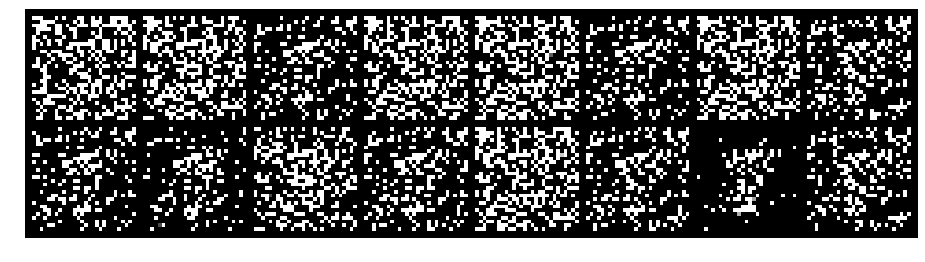

In [0]:
for epoch in range(num_epochs):
  for n_batch, (real_batch,_) in enumerate(data_loader):
    
    # Train discriminator
    real_data = Variable(images_to_vectors(real_batch))
    if torch.cuda.is_available(): real_data = real_data.cuda()
    
    # Generate fake data
    fake_data = generator(noise(real_data.size(0))).detach()
    
    # Train D
    d_error, d_pred_real, d_pred_fake = train_discriminator(d_optimizer,
                                                                real_data, fake_data)
 
    ## 2. Train Generator
    # generate fake data
    fake_data = generator(noise(real_batch.size(0)))
    
    
    # Train G
    g_error = train_generator(g_optimizer, fake_data)
    
    # Log error
    logger.log(d_error, g_error, epoch, n_batch, num_batches)
    
    
    # Display progress
    
    if (n_batch)%100 ==0:
      display.clear_output(True)
      
      # Display Images
      
      test_images = vectors_to_images(generator(test_noise)).data.cpu()
      logger.log_images(test_images, num_test_samples, epoch, n_batch, num_batches)
      
      
      
      
    # Model checkpoints
    # Model Checkpoints
    logger.save_models(generator, discriminator, epoch)
    
    
    
  